In [1]:
import numpy as np
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [3]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [4]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

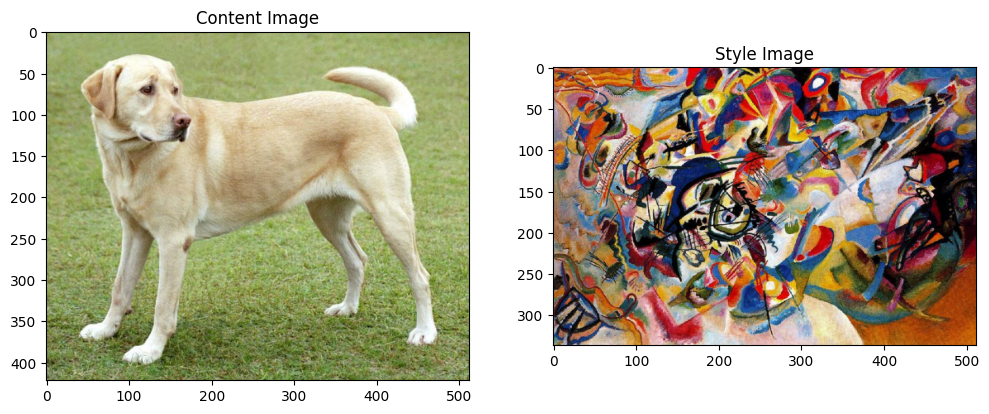

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [18]:
# x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(content_image*255, (384, 384))
network = tf.keras.applications.EfficientNetV2S(input_shape=(384, 384, 3), include_top=True, weights='imagenet')
prediction_probabilities = network(x)

In [19]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.76670516),
 ('kelpie', 0.02499141),
 ('golden_retriever', 0.010896905),
 ('dingo', 0.0076745823),
 ('Eskimo_dog', 0.0064622546)]

In [20]:
network = tf.keras.applications.EfficientNetV2S(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
# network.summary()
for layer in network.layers:
  print(layer.name)

input_layer_4
rescaling_4
stem_conv
stem_bn
stem_activation
block1a_project_conv
block1a_project_bn
block1a_project_activation
block1a_add
block1b_project_conv
block1b_project_bn
block1b_project_activation
block1b_drop
block1b_add
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block2c_expand_conv
block2c_expand_bn
block2c_expand_activation
block2c_project_conv
block2c_project_bn
block2c_drop
block2c_add
block2d_expand_conv
block2d_expand_bn
block2d_expand_activation
block2d_project_conv
block2d_project_bn
block2d_drop
block2d_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_project_conv
block3a_project_bn
block3b_expand_conv
block3b_expand_bn
block3b_expand_activation
block3b_project_conv
block3b_project_bn
block3b_drop
block3b_add
block3c_expand_conv
block3c_expand_bn
block3c

In [74]:
content_layers = ['block6o_project_conv'] 

style_layers = ['block1a_project_conv',
                'block1b_project_conv',
                'block2a_expand_conv',
                'block2a_project_conv',
                'block2b_expand_conv',
                'block2b_project_conv',
                'block2c_expand_conv',
                'block2c_project_conv',
                'block2d_expand_conv',
                'block2d_project_conv',
                'block3a_expand_conv',
                'block3a_project_conv',
                'block3b_expand_conv',
                'block3b_project_conv',
                'block3c_expand_conv',
                'block3c_project_conv',
                'block3d_expand_conv',
                'block3d_project_conv',
                'block4a_expand_conv',
                'block4a_project_conv',
                'block4b_expand_conv',
                'block4b_project_conv',
                'block4c_expand_conv',
                'block4c_project_conv',
                'block4d_expand_conv',
                'block4d_project_conv',
                'block4e_project_conv',
                'block4f_expand_conv',
                'block4f_project_conv']
# style_layers = ['block1a_project_conv',
#                 'block1b_project_conv',
#                 'block2a_project_conv',
#                 'block2b_project_conv',
#                 'block2c_project_conv',
#                 'block2d_project_conv',
#                 'block3a_project_conv',
#                 'block4a_project_conv',
#                 'block5a_project_conv',
#                 'block6a_project_conv',]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [75]:
def network_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  network = tf.keras.applications.EfficientNetV2S(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
  network.trainable = False

  outputs = [network.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([network.input], outputs)
  return model

In [76]:
x = content_image*255
x = tf.image.resize(x, (256, 256))

y = style_image*255
y = tf.image.resize(y, (256, 256))

style_extractor = network_layers(style_layers)
style_outputs = style_extractor(y)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1a_project_conv
  shape:  (1, 128, 128, 24)
  min:  -135.5589
  max:  87.029205
  mean:  -4.800266

block1b_project_conv
  shape:  (1, 128, 128, 24)
  min:  -255.21536
  max:  73.644936
  mean:  -16.036234

block2a_expand_conv
  shape:  (1, 64, 64, 96)
  min:  -179.04906
  max:  133.44664
  mean:  -4.419502

block2a_project_conv
  shape:  (1, 64, 64, 48)
  min:  -114.38633
  max:  66.899666
  mean:  -2.6707957

block2b_expand_conv
  shape:  (1, 64, 64, 192)
  min:  -146.02303
  max:  92.66213
  mean:  -9.638545

block2b_project_conv
  shape:  (1, 64, 64, 48)
  min:  -6.607134
  max:  6.808828
  mean:  0.09241887

block2c_expand_conv
  shape:  (1, 64, 64, 192)
  min:  -116.968346
  max:  73.32129
  mean:  -5.082019

block2c_project_conv
  shape:  (1, 64, 64, 48)
  min:  -6.6663504
  max:  4.8721776
  mean:  -0.012962393

block2d_expand_conv
  shape:  (1, 64, 64, 192)
  min:  -132.96332
  max:  104.79149
  mean:  -7.7503743

block2d_project_conv
  shape:  (1, 64, 64, 48)
  min:  -5.

In [77]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [78]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.network = network_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.network.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    # Preprocess the input
    inputs = tf.image.resize(inputs, (256, 256))
    preprocessed_input = inputs
    outputs = self.network(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}


In [79]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1a_project_conv
    shape:  (1, 24, 24)
    min:  -48.558704
    max:  461.1993
    mean:  30.928337

   block1b_project_conv
    shape:  (1, 24, 24)
    min:  -313.60382
    max:  1229.3877
    mean:  150.93597

   block2a_expand_conv
    shape:  (1, 96, 96)
    min:  -3743.7002
    max:  4246.67
    mean:  13.056691

   block2a_project_conv
    shape:  (1, 48, 48)
    min:  -406.41052
    max:  1394.2665
    mean:  6.0735517

   block2b_expand_conv
    shape:  (1, 192, 192)
    min:  -1528.3546
    max:  2559.9153
    mean:  31.04

   block2b_project_conv
    shape:  (1, 48, 48)
    min:  -0.35246933
    max:  0.853056
    mean:  0.011613782

   block2c_expand_conv
    shape:  (1, 192, 192)
    min:  -1057.0515
    max:  2264.472
    mean:  5.5986924

   block2c_project_conv
    shape:  (1, 48, 48)
    min:  -0.13625668
    max:  0.38644707
    mean:  0.005273338

   block2d_expand_conv
    shape:  (1, 192, 192)
    min:  -554.1825
    max:  1283.8987
    mean:  15.86

In [88]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1
content_weight=1e4

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

total_variation_weight=.001

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

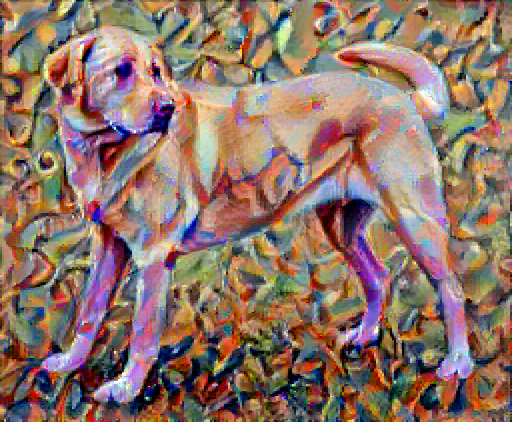

Train step: 1000
Total time: 233.1


In [89]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))